In [1]:
import os
import shutil
from pathlib import Path
from typing import Dict, List

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

### Storing Azure Key (temp)

In [3]:
os.environ["AZURE_SEARCH_KEY"] = ''

# Listing top 100 Actors

We will extract a list of actors from IMDB, by using BeautifulSoup.
We will keep a picture of each actor to serve as a test set.

In [3]:
import requests

from bs4 import BeautifulSoup

URL = "https://www.imdb.com/list/ls050274118/"


In [18]:
# Instead of doing star import :)
from fastai.data.transforms import get_image_files
from fastai.vision.utils import verify_images
from fastdownload.core import download_url

In [4]:
resp = requests.get(URL)
soup = BeautifulSoup(resp.content, 'html.parser')

In [6]:
actor_dir = Path("actors")
thumb_dir = actor_dir / "thumbnails"
thumb_dir.mkdir(exist_ok=True, parents=True)

actors_100: List[str] = list()
for img in soup.find_all("img"):
    name = img.get("alt")
    # Name of actors start with an upper case.
    # Otherwise, there is another item: "list image"
    if not name[0].isupper():
        continue
    actors_100.append(name)
    dest = thumb_dir / f"{name}.jpg"
    download_url(img.get("src"), dest, show_progress=False)

In [7]:
nb_thumbnails_downloaded = len(list(thumb_dir.glob("*.jpg")))
assert nb_thumbnails_downloaded == 100, f"{nb_thumbnails_downloaded} thumbnails found, 100 expected"

In [10]:
actors_thumbs = get_image_files(thumb_dir)
failed_thumbs = verify_images(actors_thumbs)
assert not failed_thumbs, f"Images corrupted: {failed_thumbs}"

# Downloading images for actors

In [28]:
AZURE_SEARCH_KEY = os.environ['AZURE_SEARCH_KEY']
download_dir = actor_dir / "download"


In [36]:
shutil.rmtree(download_dir, ignore_errors=True)
for actor in actors_100[:3]:
    dest = download_dir / actor
    dest.mkdir(exist_ok=True, parents=True)
    for age in ["young", "old"]:
      results = search_images_bing(key, f'"{actor}" {age}')
      download_images(dest / f"{actor}_{age}", urls=results.attrgot('contentUrl'))


In [41]:
# As we can have jpg, JPEG, gif, png, ..., we will do a glob based on hierarchy
for img in download_dir.glob("*/*/*.*"):

    actor, age = img.parent.name.split("_")
    actor_dir = img.parent.parent
    assert actor_dir.name == actor, f"{actor_dir} not matching name of actor {actor}"
    img.rename(actor_dir / f"{actor}-{age}-{img.name}")

# We will then check that all files have been copied and clean up directories


In [51]:
for path in download_dir.glob("*/*"):
  if path.is_dir() and path.name.endswith(("_young", "_old")):
    nb_files = len(list(path.glob("*.*")))
    if nb_files:
      print(f"Directory {path} not empty ({nb_files} children)")
    else:
      path.rmdir()
      print(f"Deleted empty directory {path}")

In [11]:
actors_fns = get_image_files(download_dir)
failed = verify_images(actors_fns)


In [12]:
print(f"Cleaning up {len(failed)} corrupted images in {download_dir}")
failed.map(Path.unlink)
print("=> done")

Cleaning up 44 corrupted images in actors/download
=> done


# Learning (CV)

In [6]:
# We reload the name of actors from files download
# (in case we need to restart the Kernel)
download_dir = Path("actors") / "download"
actors_100 = [d.name for d in download_dir.glob("*") if d.is_dir()]
len(actors_100)

3

In [8]:
from fastai.data.block import DataBlock

In [14]:
actors_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
)
dls = actors_block.dataloaders(download_dir)

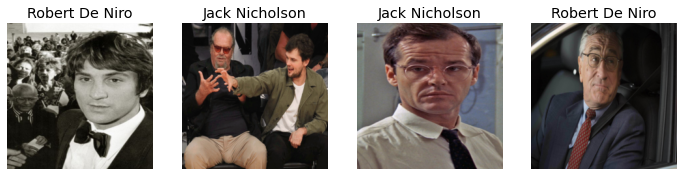

In [15]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time


epoch,train_loss,valid_loss,error_rate,time
0,1.596716,1.094552,0.402439,02:27


epoch,train_loss,valid_loss,error_rate,time
0,0.929055,0.787084,0.280488,03:13


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Cleaning

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():
  shutil.move(str(cleaner.fns[idx]), path/cat)

## Improving Model